# **Modèle sur mesure avancé**

Développement d'un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet.

## **1. Importation des données**

In [6]:
#chargement des données
import pandas as pd
D = pd.read_csv("data/training.1600000.processed.noemoticon.csv",sep=",",names=['target', 'id', 'date', 'flag', 'user', 'text'],encoding="UTF",encoding_errors="ignore")
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
#distribution des classes
print(D.target.value_counts())

0    800000
4    800000
Name: target, dtype: int64


## **2. Echantillonnage**

In [8]:
# récupération des targets
target_values = D['target'].value_counts().index.to_list()
print(target_values)

# échantillonage,  on garde 15000 tweets de chaque target
list_targets = []
list_texts = []
for target in target_values:
    dataframe = D[D['target'] == target].sample(n=15000, random_state=0)
    list_targets.extend(dataframe['target'])
    list_texts.extend(dataframe['text'])

DS = pd.DataFrame()
DS['text'] = list_texts
DS['target'] = list_targets

DS.head()

[0, 4]


,text,target
0,"oh god whits pissed n shes drivin, in the rain...",0
1,driving back from myrtle beach,0
2,Saying byebye to AM's Refuge and Extension wi...,0
3,@SarahSaner Did you she fell of her horse agai...,0
4,@SalioElSol08 save me any.,0


## **3. Nettoyage**

In [9]:
#****************************************
#préparation des librairies et des outils
#pour le nettoyage des tweets
#****************************************

#expressions régulières
import re

#ponctuations
import string
ponctuations = list(string.punctuation)
print(ponctuations)

#tokénisation
#import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

#lemmatisation
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
lem = WordNetLemmatizer()
stemmer = PorterStemmer()

#charger les stopwords
#nltk.download('stopwords')
from nltk.corpus import stopwords
mots_vides = stopwords.words('english')
print('\n')
print(mots_vides)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'wh

### 3.1 Lemmatisation

In [10]:
#fonction pour nettoyage de chaque document
#tweet = corps du tweet = document
#ponctuations : liste des ponctuations
#stopwords : liste des stopwords à retirer
#lem : fonction pour la lemmatisation des termes
def clean_tweet_lem(tweet,ponctuations,stopwords,lem):
    #harmonisation de la casse
    temp = tweet.lower()
    #retirer les contractions en anglais
    temp = re.sub("'", "", temp)
    #retrait des @ (mentions)
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    #retrait des # (hashtags)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    #retrait des liens web (http et https)
    temp = re.sub(r'http\S+', '', temp)
    #retrait des ponctuations
    temp = "".join([char for char in list(temp) if not (char in ponctuations)])
    #retrait des nombres   
    temp = re.sub("[0-9]","", temp)
    #tokenisation
    temp = word_tokenize(temp)
    #lemmatisation des termes
    temp = [lem.lemmatize(mot) for mot in temp]
    #retrait des stopwords
    temp = [mot for mot in temp if not mot in stopwords]
    #retirer les tokens de moins de 3 caractères
    temp = [mot for mot in temp if len(mot) >= 3]    
    #reformer la chaîne
    temp = " ".join(mot for mot in temp)
    return temp

In [11]:
#appliquer le nettoyage au corpus
corpus_lem = list(DS.text)
corpus_lem = [clean_tweet_lem(doc,ponctuations,mots_vides,lem) for doc in corpus_lem]

In [12]:
#nouveau data frame
DC_lem = pd.DataFrame({'target':(DS.target==4).astype('int32'),'text':corpus_lem})

#comparaison avant...
DS.head(10)

,text,target
0,"oh god whits pissed n shes drivin, in the rain...",0
1,driving back from myrtle beach,0
2,Saying byebye to AM's Refuge and Extension wi...,0
3,@SarahSaner Did you she fell of her horse agai...,0
4,@SalioElSol08 save me any.,0
5,bad day. Need to study more. Taking a break. E...,0
6,ready to get off work ugh...then i have to stu...,0
7,woke up with a headache,0
8,my bestie leaves for a week today,0
9,Or maybe it's the other way around. Europeans ...,0


In [13]:
#... et après nettoyage
DC_lem.head(10)

,target,text
0,0,god whit pissed shes drivin rain heelllpppp lol
1,0,driving back myrtle beach
2,0,saying byebye refuge extension great concert k...
3,0,fell horse amp landed hospital apparently pap ...
4,0,save
5,0,bad day need study taking break eating stress ...
6,0,ready get work ughthen study exam moro head at...
7,0,woke headache
8,0,bestie leaf week today
9,0,maybe way around european showing party


In [18]:
#des tweets vides après nettoyage ?
print(DC_lem.loc[DC_lem.text==""].shape[0])

158


In [19]:
#retrait des tweets correspondants
DC_lem_ok = DC_lem.loc[DC_lem.text != ""]
print(DC_lem_ok.shape)

(29842, 2)


### 3.2 Stemmatisation

In [14]:
#fonction pour nettoyage de chaque document
#tweet = corps du tweet = document
#ponctuations : liste des ponctuations
#stopwords : liste des stopwords à retirer
#stemmer : fonction pour la stemmatisation des termes
def clean_tweet_stemmer(tweet,ponctuations,stopwords,stemmer):
    #harmonisation de la casse
    temp = tweet.lower()
    #retirer les contractions en anglais
    temp = re.sub("'", "", temp)
    #retrait des @ (mentions)
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    #retrait des # (hashtags)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    #retrait des liens web (http et https)
    temp = re.sub(r'http\S+', '', temp)
    #retrait des ponctuations
    temp = "".join([char for char in list(temp) if not (char in ponctuations)])
    #retrait des nombres   
    temp = re.sub("[0-9]","", temp)
    #tokenisation
    temp = word_tokenize(temp)
    #lemmatisation des termes
    temp = [stemmer.stem(mot) for mot in temp]
    #retrait des stopwords
    temp = [mot for mot in temp if not mot in stopwords]
    #retirer les tokens de moins de 3 caractères
    temp = [mot for mot in temp if len(mot) >= 3]    
    #reformer la chaîne
    temp = " ".join(mot for mot in temp)
    return temp

In [15]:
#appliquer le nettoyage au corpus
corpus_stem = list(DS.text)
corpus_stem = [clean_tweet_stemmer(doc,ponctuations,mots_vides,stemmer) for doc in corpus_stem]

In [16]:
#nouveau data frame
DC_stem = pd.DataFrame({'target':(DS.target==4).astype('int32'),'text':corpus_stem})

#comparaison avant...
DS.head(10)

,text,target
0,"oh god whits pissed n shes drivin, in the rain...",0
1,driving back from myrtle beach,0
2,Saying byebye to AM's Refuge and Extension wi...,0
3,@SarahSaner Did you she fell of her horse agai...,0
4,@SalioElSol08 save me any.,0
5,bad day. Need to study more. Taking a break. E...,0
6,ready to get off work ugh...then i have to stu...,0
7,woke up with a headache,0
8,my bestie leaves for a week today,0
9,Or maybe it's the other way around. Europeans ...,0


In [17]:
#... et après nettoyage
DC_stem.head(10)

,target,text
0,0,god whit piss drivin rain heelllpppp lol
1,0,drive back myrtl beach
2,0,say byeby refug extens great concert kyle joaquin
3,0,fell hors amp land hospit appar pap startl hors
4,0,save ani
5,0,bad day need studi take break eat stress food joy
6,0,readi get work ughthen studi exam moro head at...
7,0,woke headach
8,0,besti leav week today
9,0,mayb way around european show parti


In [20]:
#des tweets vides après nettoyage ?
print(DC_stem.loc[DC_stem.text==""].shape[0])

168


In [21]:
#retrait des tweets correspondants
DC_stem_ok = DC_stem.loc[DC_stem.text != ""]
print(DC_stem_ok.shape)

(29832, 2)


## **4. Subdivision train-test**

In [22]:
#partition app-test
from sklearn.model_selection import train_test_split
dfTrain_lem, dfTest_lem = train_test_split(DC_lem_ok,train_size=0.7,stratify=DC_lem_ok.target,random_state=0)

#vérification
print(dfTrain_lem.shape)
print(dfTest_lem.shape)

(20889, 2)
(8953, 2)


In [23]:
dfTrain_stem, dfTest_stem = train_test_split(DC_stem_ok,train_size=0.7,stratify=DC_stem_ok.target,random_state=0)

#vérification
print(dfTrain_stem.shape)
print(dfTest_stem.shape)

(20882, 2)
(8950, 2)


## **5. Tokenisation**

In [69]:
from tensorflow import keras

In [24]:
#tokénisation avec Keras
#num_words = None => sans limitation du nombre de termes à extraire
from keras.preprocessing.text import Tokenizer
tk_lem = Tokenizer(num_words=None)

#création du dictionnaire à partir des documents
#de l'échantillon d'apprentissage
tk_lem.fit_on_texts(dfTrain_lem.text)

#nombre de documents traités
print(tk_lem.document_count)

20889


In [82]:
import io
import json

In [83]:
tokenizer_json = tk_lem.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [36]:
#taille du dictionnaire
dico_size_lem = len(tk_lem.word_counts)
print(dico_size_lem)

20927


In [26]:
#liste des termes avec leur indice - les 10 premiers
print(list(tk_lem.word_index.items())[:10])

[('day', 1), ('get', 2), ('good', 3), ('like', 4), ('got', 5), ('work', 6), ('love', 7), ('time', 8), ('dont', 9), ('cant', 10)]


In [27]:
#les 10 derniers
print(list(tk_lem.word_index.items())[-10:])

[('hammondquot', 20918), ('thre', 20919), ('meron', 20920), ('dubbing', 20921), ('hintay', 20922), ('ttown', 20923), ('shervon', 20924), ('meowwwww', 20925), ('fiesty', 20926), ('hybridized', 20927)]


On procède de la même façon avec nos données stemmatisées.

In [37]:
tk_stem = Tokenizer(num_words=None)

#création du dictionnaire à partir des documents
#de l'échantillon d'apprentissage
tk_stem.fit_on_texts(dfTrain_stem.text)

#nombre de documents traités
print(f"Nombre de documents traités : {tk_stem.document_count}")

#taille du dictionnaire
dico_size_stem = len(tk_stem.word_counts)
print(f"Taille du dictionnaire : {dico_size_stem}")

Nombre de documents traités : 20882
Taille du dictionnaire : 18342


## **6. Séquences de tokens**

In [29]:
#transformation des documents en séquences de tokens
#cf. la doc
seqTrain_lem = tk_lem.texts_to_sequences(dfTrain_lem.text)
print(seqTrain_lem[:3])

[[931, 18], [370, 33, 1242, 18, 7336, 45, 804, 137, 423, 47, 4965], [30, 129, 230, 8, 60]]


In [31]:
#tweet corresp.
print(dfTrain_lem.text[:3])

825                                               ohh want
12557    tried make quoti want fallofautumndistroquot d...
11298                              feel old cause time bed
Name: text, dtype: object


C:\Users\Nolwenn\AppData\Local\Temp\ipykernel_11940\3961145536.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(dfTrain_lem.text[:3])


In [32]:
#longueur max des documents
#dans l'échantillon train
import numpy
max_length_lem = numpy.max(numpy.array([len(doc) for doc in seqTrain_lem]))
print(max_length_lem)

21


In [33]:
#transformer en pad_sequences pour 
#manipuler une structure de taille fixe
#maxlen = max_length + marge pour éventuellement
#gérer les docs. plus longs en déploiement

#marge_length
marge_length = 5

from keras.utils import pad_sequences
padTrain_lem = pad_sequences(seqTrain_lem,maxlen=max_length_lem + marge_length,padding='post')

#les 3 premiers documents
print(padTrain_lem[:3,:])

[[ 931   18    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 370   33 1242   18 7336   45  804  137  423   47 4965    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  30  129  230    8   60    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


On procède de la même façon avec les données stemmatisées.

In [34]:
#transformation des documents en séquences de tokens
seqTrain_stem = tk_stem.texts_to_sequences(dfTrain_stem.text)
max_length_stem = numpy.max(numpy.array([len(doc) for doc in seqTrain_stem]))
print(f"Longueur max : {max_length_stem}")

#transformer en pad_sequences pour 
#manipuler une structure de taille fixe
#maxlen = max_length + marge pour éventuellement
#gérer les docs. plus longs en déploiement

#marge_length
marge_length = 5
padTrain_stem = pad_sequences(seqTrain_stem,maxlen=max_length_stem + marge_length,padding='post')

Longueur max : 22


## **7. Word Embedding**

### 7.1 Glove

[GloVe](https://nlp.stanford.edu/projects/glove/) : Global Vectors for Word Representation

In [63]:
import numpy

In [64]:

#structure dictionnaire pour stocker les couples
#termes, vecteurs
embeddings_index = {}
#ouvrir le fichier en lecture
#représentation dim = 200
with open("glove.twitter.27B.200d.txt","r",encoding="utf-8") as f:
    #lire ligne par ligne et décomposer
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = numpy.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs


In [65]:
#vérification du nombre de termes
print("Found %s word vectors." % len(embeddings_index))

Found 1193514 word vectors.


In [66]:
#nombre de tokens
#taille du dictionnaire + 1
num_tokens = dico_size_lem + 1

#dimension de représentation
#puisque nous avons choisi "glove.6B.50d.txt"
embedding_dim = 200

#nombre de termes trouvés
#et liste des non trouvés
hit = 0
misses = []

#*****************************************
#remplir la matrice avec les coordonnées
#issues de la représentation pré-entraînée
#*****************************************
#initialisation avec des valeurs 0
embedding_matrix = numpy.zeros((num_tokens,embedding_dim))
#remplissage à partir des représentations pré-entraînées
#pourvu que le terme (de notre dictionnaire) recherché soit présent
#dans la représentation pré-entraînée de GloVe
for word, i in tk_lem.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if not(embedding_vector is None):
        #compléter la ligne n°i
        embedding_matrix[i] = embedding_vector
        #compteur
        hit = hit + 1
    else:
        misses.append(word)
        
#affichage de contrôle
print('Termes du dico trouvés {0} et non trouvés {1}'.format(hit,len(misses)))

Termes du dico trouvés 15403 et non trouvés 5524


In [67]:
#qqs exemples de termes non recensés
#dans la représentation pré-entraînée
print(misses[:20])

['wwwtweeteraddercom', 'quoti', 'quotthe', 'ampamp', 'booo', 'boooo', 'gtlt', 'wwwtweeterfollowcom', 'atampt', 'ughhh', 'it´s', 'lvatt', 'loveeee', 'mequot', 'meeee', 'quotyou', 'heyyy', 'knowww', 'yeahhh', 'twitterfon']


### 7.2 Word2Vec

In [ ]:
from gensim.models import Word2Vec

In [ ]:
word2vec_model =  Word2Vec()

## **8. Modélisation**

### 8.1 Modèle simple avec embedding

In [38]:
#créer un modèle
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Embedding

#perceptron multicouche
#==> output_dim précise la taille de l'espace de
#représentation dans laquelle seront projetés les termes
#==> input_dim = dico_size + 1 parce que l'index
#des termes commence à la colonne 1 (la colonne 0 existe mais n'est pas associée à un terme)
pmc_lem = Sequential()
pmc_lem.add(Embedding(input_dim = dico_size_lem + 1, output_dim = 10, input_length = max_length_lem + marge_length))
pmc_lem.add(Flatten())
pmc_lem.add(Dense(units=1,activation="sigmoid"))

#structure du réseau
print(pmc_lem.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 10)            209280    
                                                                 
 flatten (Flatten)           (None, 260)               0         
                                                                 
 dense (Dense)               (None, 1)                 261       
                                                                 
Total params: 209,541
Trainable params: 209,541
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
#paramétrage de l'algorithme d'apprentissage
pmc_lem.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])

#lancement - une partie du train est réservée pour la validation
#c.-à-d. pour un suivi plus réaliste des performances 
history_lem = pmc_lem.fit(padTrain_lem,dfTrain_lem.target,epochs=10,validation_split=0.2)

Epoch 1/10


c:\Users\Nolwenn\Documents\AI_Engineer\Projet_07\ingenieurIA-P7\project07_env\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


523/523 [==============================] - 1s 2ms/step - loss: 0.6676 - accuracy: 0.6105 - val_loss: 0.6077 - val_accuracy: 0.7140
Epoch 2/10
523/523 [==============================] - 1s 2ms/step - loss: 0.5183 - accuracy: 0.7828 - val_loss: 0.5321 - val_accuracy: 0.7348
Epoch 3/10
523/523 [==============================] - 1s 2ms/step - loss: 0.3994 - accuracy: 0.8434 - val_loss: 0.5251 - val_accuracy: 0.7377
Epoch 4/10
523/523 [==============================] - 1s 2ms/step - loss: 0.3110 - accuracy: 0.8862 - val_loss: 0.5344 - val_accuracy: 0.7326
Epoch 5/10
523/523 [==============================] - 1s 1ms/step - loss: 0.2432 - accuracy: 0.9159 - val_loss: 0.5565 - val_accuracy: 0.7262
Epoch 6/10
523/523 [==============================] - 1s 2ms/step - loss: 0.1924 - accuracy: 0.9414 - val_loss: 0.5761 - val_accuracy: 0.7228
Epoch 7/10
523/523 [==============================] - 1s 2ms/step - loss: 0.1544 - accuracy: 0.9560 - val_loss: 0.6044 - val_accuracy: 0.7202
Epoch 8/10
523/52

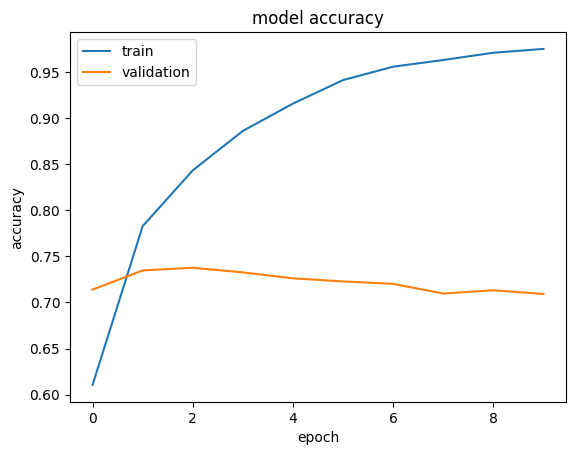

In [41]:
#graphique accuracy
import matplotlib.pyplot as plt

#fonction pour évolution de l'accuracy
def graphique(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
#appel de la fonction
graphique(history_lem)

Et avec nos données stemmatisées.

In [42]:
pmc_stem = Sequential()
pmc_stem.add(Embedding(input_dim = dico_size_stem + 1, output_dim = 10, input_length = max_length_stem + marge_length))
pmc_stem.add(Flatten())
pmc_stem.add(Dense(units=1,activation="sigmoid"))

#structure du réseau
print(pmc_stem.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 27, 10)            183430    
                                                                 
 flatten_1 (Flatten)         (None, 270)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 271       
                                                                 
Total params: 183,701
Trainable params: 183,701
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
#paramétrage de l'algorithme d'apprentissage
pmc_stem.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])

#lancement - une partie du train est réservée pour la validation
#c.-à-d. pour un suivi plus réaliste des performances 
history_stem = pmc_stem.fit(padTrain_stem,dfTrain_stem.target,epochs=10,validation_split=0.2)

Epoch 1/10


c:\Users\Nolwenn\Documents\AI_Engineer\Projet_07\ingenieurIA-P7\project07_env\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


523/523 [==============================] - 1s 2ms/step - loss: 0.6596 - accuracy: 0.6296 - val_loss: 0.5931 - val_accuracy: 0.7108
Epoch 2/10
523/523 [==============================] - 1s 1ms/step - loss: 0.5090 - accuracy: 0.7801 - val_loss: 0.5301 - val_accuracy: 0.7383
Epoch 3/10
523/523 [==============================] - 1s 1ms/step - loss: 0.4075 - accuracy: 0.8374 - val_loss: 0.5259 - val_accuracy: 0.7436
Epoch 4/10
523/523 [==============================] - 1s 2ms/step - loss: 0.3325 - accuracy: 0.8761 - val_loss: 0.5365 - val_accuracy: 0.7422
Epoch 5/10
523/523 [==============================] - 1s 1ms/step - loss: 0.2710 - accuracy: 0.9055 - val_loss: 0.5561 - val_accuracy: 0.7343
Epoch 6/10
523/523 [==============================] - 1s 1ms/step - loss: 0.2219 - accuracy: 0.9274 - val_loss: 0.5818 - val_accuracy: 0.7268
Epoch 7/10
523/523 [==============================] - 1s 1ms/step - loss: 0.1839 - accuracy: 0.9420 - val_loss: 0.6083 - val_accuracy: 0.7216
Epoch 8/10
523/52

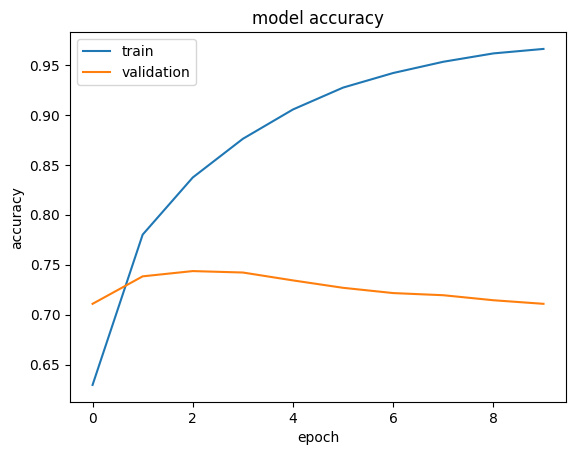

In [44]:
#appel de la fonction
graphique(history_stem)

### 8.2 Modèle avec embedding Glove

In [70]:
#construction de la couche initiale embeddings
#à partir de la représentation pré-entraînée
embedding_layer = Embedding(
    input_dim = num_tokens,
    output_dim = embedding_dim,
    input_length = max_length_lem + marge_length,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),#/!\ très important
    trainable = False #/!\ très important !!!
)

In [71]:
pmc_glove = Sequential()
pmc_glove.add(embedding_layer)
pmc_glove.add(Flatten())
pmc_glove.add(Dense(units=1,activation="sigmoid"))

#structure du réseau
print(pmc_glove.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 26, 200)           4185600   
                                                                 
 flatten_2 (Flatten)         (None, 5200)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 5201      
                                                                 
Total params: 4,190,801
Trainable params: 5,201
Non-trainable params: 4,185,600
_________________________________________________________________
None


In [72]:
#paramétrage de l'algorithme d'apprentissage
pmc_glove.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])

#lancement - une partie du train est réservée pour la validation
#c.-à-d. pour un suivi plus réaliste des performances 
history_glove = pmc_glove.fit(padTrain_lem,dfTrain_lem.target,epochs=10,validation_split=0.2)

Epoch 1/10


c:\Users\Nolwenn\Documents\AI_Engineer\Projet_07\ingenieurIA-P7\project07_env\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


523/523 [==============================] - 1s 1ms/step - loss: 0.5781 - accuracy: 0.7026 - val_loss: 0.5397 - val_accuracy: 0.7315
Epoch 2/10
523/523 [==============================] - 1s 1ms/step - loss: 0.5106 - accuracy: 0.7552 - val_loss: 0.5300 - val_accuracy: 0.7432
Epoch 3/10
523/523 [==============================] - 1s 1ms/step - loss: 0.4885 - accuracy: 0.7695 - val_loss: 0.5337 - val_accuracy: 0.7384
Epoch 4/10
523/523 [==============================] - 1s 1ms/step - loss: 0.4752 - accuracy: 0.7778 - val_loss: 0.5360 - val_accuracy: 0.7434
Epoch 5/10
523/523 [==============================] - 1s 1ms/step - loss: 0.4656 - accuracy: 0.7819 - val_loss: 0.5429 - val_accuracy: 0.7403
Epoch 6/10
523/523 [==============================] - 1s 1ms/step - loss: 0.4593 - accuracy: 0.7861 - val_loss: 0.5486 - val_accuracy: 0.7350
Epoch 7/10
523/523 [==============================] - 1s 1ms/step - loss: 0.4539 - accuracy: 0.7906 - val_loss: 0.5532 - val_accuracy: 0.7348
Epoch 8/10
523/52

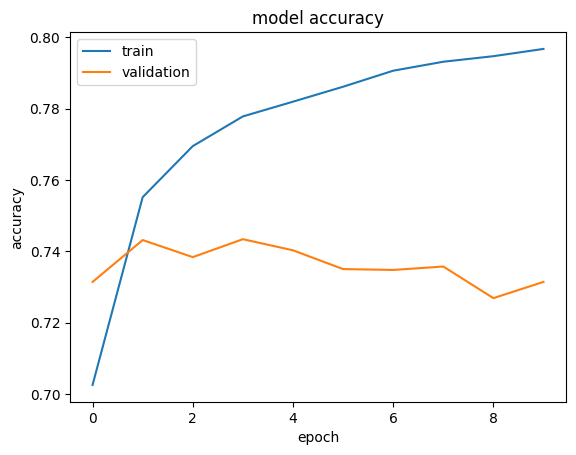

In [73]:
graphique(history_glove)

### 8.3 Modèle avec embedding et LSTM

In [ ]:
from keras.layers import LSTM

In [75]:
lstm = Sequential()
lstm.add(embedding_layer)
lstm.add(LSTM(256))
lstm.add(Dense(1,activation='sigmoid'))
lstm.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(lstm.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 26, 200)           4185600   
                                                                 
 lstm_6 (LSTM)               (None, 256)               467968    
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4,653,825
Trainable params: 468,225
Non-trainable params: 4,185,600
_________________________________________________________________
None


In [76]:
#paramétrage de l'algorithme d'apprentissage
lstm.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])

#lancement - une partie du train est réservée pour la validation
#c.-à-d. pour un suivi plus réaliste des performances 
history_lstm = lstm.fit(padTrain_lem,dfTrain_lem.target,epochs=10,validation_split=0.2)

Epoch 1/10


c:\Users\Nolwenn\Documents\AI_Engineer\Projet_07\ingenieurIA-P7\project07_env\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


523/523 [==============================] - 22s 40ms/step - loss: 0.5430 - accuracy: 0.7305 - val_loss: 0.5090 - val_accuracy: 0.7578
Epoch 2/10
523/523 [==============================] - 21s 39ms/step - loss: 0.4939 - accuracy: 0.7641 - val_loss: 0.5067 - val_accuracy: 0.7614
Epoch 3/10
523/523 [==============================] - 21s 40ms/step - loss: 0.4741 - accuracy: 0.7780 - val_loss: 0.5287 - val_accuracy: 0.7310
Epoch 4/10
523/523 [==============================] - 21s 40ms/step - loss: 0.4584 - accuracy: 0.7850 - val_loss: 0.4994 - val_accuracy: 0.7544
Epoch 5/10
523/523 [==============================] - 21s 40ms/step - loss: 0.4316 - accuracy: 0.7986 - val_loss: 0.5052 - val_accuracy: 0.7693
Epoch 6/10
523/523 [==============================] - 21s 41ms/step - loss: 0.4044 - accuracy: 0.8171 - val_loss: 0.5600 - val_accuracy: 0.7666
Epoch 7/10
523/523 [==============================] - 21s 40ms/step - loss: 0.3703 - accuracy: 0.8362 - val_loss: 0.5604 - val_accuracy: 0.7609
Epo

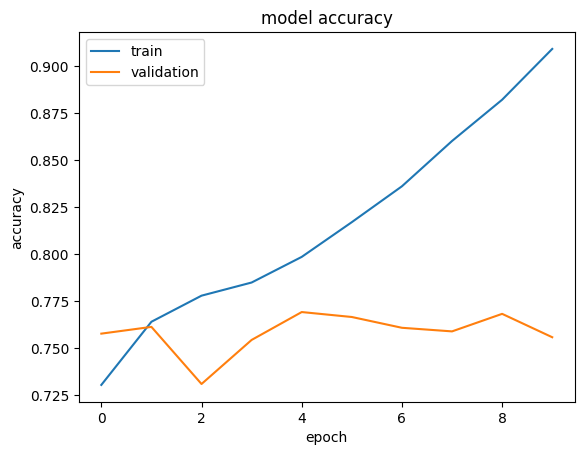

In [77]:
#appel de la fonction
graphique(history_lstm)

In [80]:
# sauvegarde du modèle
lstm.save('lstm_model.h5')

### 8.3 Modèle avec embedding et LSTM bidirectionnel

In [79]:
from keras.layers import Bidirectional, Dropout

In [ ]:
lstm_bidir = Sequential()
lstm_bidir.add(embedding_layer)
lstm_bidir.add(Bidirectional(LSTM(128)))
lstm_bidir.add(Dense(100, input_shape=(10000,), activation="relu"))
lstm_bidir.add(Dropout(0.2))
lstm_bidir.add(Dense(10, activation="relu"))
lstm_bidir.add(Dense(1,activation='sigmoid'))
lstm_bidir.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(lstm_bidir.summary())

### 8.4 Modèle avec BERT

## **9. Evaluation**

In [46]:
#pad pour le test
seqTest_lem = tk_lem.texts_to_sequences(dfTest_lem.text)
padTest_lem = pad_sequences(seqTest_lem,maxlen=max_length_lem + marge_length,padding='post')

seqTest_stem = tk_stem.texts_to_sequences(dfTest_stem.text)
padTest_stem = pad_sequences(seqTest_stem,maxlen=max_length_stem + marge_length,padding='post')

#tweets
print(dfTest_lem.text[:3])

#vérif.
print('\n')
print(padTest_lem[:3,:])

26279                               know walked upon dream
10697                yay reunited cant upload photo though
24542    think election rejoicement tread water really ...
Name: text, dtype: object


[[  16 1614 4217  311    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 110   10 1198  336   59    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  22 2528 5995  525   17   72    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


C:\Users\Nolwenn\AppData\Local\Temp\ipykernel_11940\1443794578.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(dfTest_lem.text[:3])


In [47]:
#premier modèle avec lemmatisation
#évaluation en test avec evaluate()
print(pmc_lem.evaluate(padTest_lem,dfTest_lem.target))

280/280 [==============================] - 0s 762us/step - loss: 0.7488 - accuracy: 0.7075
[0.7487790584564209, 0.7074723839759827]


In [48]:
#2nd modèle avec stemmatisation
#évaluation en test avec evaluate()
print(pmc_stem.evaluate(padTest_stem,dfTest_stem.target))

280/280 [==============================] - 0s 771us/step - loss: 0.7327 - accuracy: 0.7086
[0.7326883673667908, 0.7086033225059509]


In [78]:
# évaluation modèle LSTM avec Glove et lemmatisation
print(lstm.evaluate(padTest_lem,dfTest_lem.target))

280/280 [==============================] - 5s 16ms/step - loss: 0.6765 - accuracy: 0.7435
[0.6764681339263916, 0.743549644947052]


In [74]:
# évaluation modèle avec embedding Glove
print(pmc_glove.evaluate(padTest_lem,dfTest_lem.target))

280/280 [==============================] - 0s 841us/step - loss: 0.5717 - accuracy: 0.7221
[0.5717283487319946, 0.7221043109893799]


## **10. Choix du modèle**

## **11. Simulation sur un jeu de données plus important**

## **Conclusion**